In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-exp")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1715959168737, experiment_id='1', last_update_time=1715959168737, lifecycle_stage='active', name='nyc-taxi-exp', tags={}>

In [3]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    print("Q1. number of columns:",df.shape[1])
    
    df['duration'] = df["tpep_dropoff_datetime"]-df["tpep_pickup_datetime"]
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    print("Q2. duration standard deviation:",df.duration.std())
    
    # only use rides which were between 1 to 60 minutes
    valid_rows = (df.duration>=1) & (df.duration<=60)
    print("Q3. valid rows percentage:",valid_rows.mean())
    
    df = df[valid_rows]
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)
    
    return df

In [4]:
train_df = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
val_df = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

Q1. number of columns: 19
Q2. duration standard deviation: 42.59435124195458
Q3. valid rows percentage: 0.9812202822125979
Q1. number of columns: 19
Q2. duration standard deviation: 42.84210176105113
Q3. valid rows percentage: 0.9800944077722545


In [5]:
train_df.duration.min(),train_df.duration.max()

(1.0, 60.0)

In [6]:
len(train_df),len(val_df)

(3009173, 2855951)

In [7]:
# train_df["PU_DO"] = train_df["PULocationID"] + "_" + train_df["DOLocationID"]
# val_df["PU_DO"] = val_df["PULocationID"] + "_" + val_df["DOLocationID"]
# train_df["PU_DO"].head()

In [8]:
# train_df.drop("PU_DO",inplace=True,axis=1)
# val_df.drop("PU_DO",inplace=True,axis=1)
#
train_df.shape

(3009173, 20)

In [9]:
categorical = ["PULocationID", "DOLocationID"]
# categorical = ["PU_DO"]
# numerical = ["trip_distance"]
numerical = []

dv = DictVectorizer()

train_dicts = train_df[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

train_dicts = val_df[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(train_dicts)

In [10]:
target = "duration"
y_train = train_df[target].values
y_val = val_df[target].values

In [11]:
print("Q4. data final shape:",X_train.shape)

Q4. data final shape: (3009173, 515)


In [12]:
X_val.shape

(2855951, 515)

In [13]:
with mlflow.start_run():
    mlflow.set_tag("Scientist","Anuj Panthri")
    mlflow.set_tag("model_type","linear_regression")

    mlflow.log_param("training_data","https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
    mlflow.log_param("validation_data","https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    
    y_pred = lr.predict(X_train)
    rmse = mean_squared_error(y_train, y_pred, squared=False)
    print("Q5. train RMSE:",rmse)
    mlflow.log_metric("train_rmse",rmse)
    
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print("Q6. val RMSE:",rmse)
    mlflow.log_metric("val_rmse",rmse)

Q5. train RMSE: 7.649261932106969
Q6. val RMSE: 7.811818743246608


/home/codespace/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


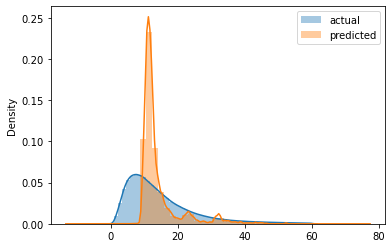

In [53]:
sns.distplot(y_val,label="actual")
sns.distplot(y_pred,label="predicted")
plt.legend()

In [16]:
# !mkdir models

In [17]:
with open("models/lin_reg.bin","wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [57]:
# lasso = Lasso()
# lasso.fit(X_train,y_train)

# y_pred = lasso.predict(X_val)

# mean_squared_error(y_val, y_pred, squared=False)

In [55]:
# sns.distplot(y_val,label="actual")
# sns.distplot(y_pred,label="predicted")
# plt.legend()

In [58]:
# reading the pickled objects
pickle.load(open("models/lin_reg.bin","rb"))

(DictVectorizer(), LinearRegression())